# **Treniranje Faster R-CNN detekciju objekata na slikama krvnih stanica**

## **Install required packages**

In [1]:
!pip install torch torchvision onnx onnxruntime

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib jupyter tf_slim

!pip install -q pycocotools

     |████████████████████████████████| 7.4MB 4.1MB/s 
     |████████████████████████████████| 4.4MB 40.3MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unsele

## **Clone the repository**

In [2]:
import os

%cd /content

repo_url = 'https://gitlab.com/Frontlines/diplomski_raspoznavanje_stanica.git'
repo_dir_path = os.path.abspath(os.path.join(os.path.basename(repo_url).split('.')[0]))

!git clone {repo_url}

/content
Cloning into 'diplomski_raspoznavanje_stanica'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 339 (delta 193), reused 291 (delta 151), pack-reused 0
Receiving objects: 100% (339/339), 1.66 GiB | 24.12 MiB/s, done.
Resolving deltas: 100% (193/193), done.
Checking out files: 100% (46/46), done.


In [3]:
%cd {repo_dir_path}
!git pull

/content/diplomski_raspoznavanje_stanica
Already up to date.


## **Prepare Datasets**

In [4]:
%cd /content
%mkdir -p object-detection/data
%mkdir -p object-detection/models/FasterRCNN
%cd object-detection/data

/content
/content/object-detection/data


In [5]:
# dataset with wbc images and labels
%rm -r /content/object-detection/data/*

# dataset sa oznakama za WBC
#!curl -L "https://app.roboflow.com/ds/FC1D6RVUAO?key=LDGm8IqBsH" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip # new dataset with horizontal flip, skew and rotate transformations and image resize to: (800x600)
!curl -L "https://app.roboflow.com/ds/DgjdzAMNru?key=R92fUIo2FX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip # new dataset with horizontal flip, skew and rotate transformations and image resize to: (480x480)

# dataset sa oznakama za krvne stanice (WBC,RBC, Platelets) num_of_classes treba postaviti na 3
#!curl -L "https://app.roboflow.com/ds/NT5T1vNy2m?key=2Js0aHhgnb" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip # 480x480

rm: cannot remove '/content/object-detection/data/*': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1384      0 --:--:-- --:--:-- --:--:--  1384
100 9539k  100 9539k    0     0  2700k      0  0:00:03  0:00:03 --:--:-- 3549k
Archive:  roboflow.zip
 extracting: test/20180926-60_png.rf.048f04a5ae51521af3bf05d53a9c9449.jpg  
 extracting: test/20180926-55_png.rf.18246f58ab549c33d0c82d5ae0059b62.jpg  
 extracting: test/20180926-98_png.rf.48a530185b7bec0bd4e5118e067ba63b.jpg  
 extracting: test/20180926-49_png.rf.9d7e64174cfef2de3688edeb7f3397ed.jpg  
 extracting: test/20180928-15_png.rf.9b8cf9a2c37ba3c09b3e267c33e7f371.jpg  
 extracting: test/20180928-94_png.rf.4f246d9af4f59035039e93428ef1a645.jpg  
 extracting: test/20180928-83_png.rf.1e7ecc0a53dbce587cf0c95bfc5d2b11.jpg  
 extracting: test/20180928-79_png.rf.6cc9ec576c95

Mount Google Drive to quickly access or copy trained models.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Copy files from drive to runtime instance

In [7]:
%mkdir -p /content/object-detection/models/pretrained
!cp "/content/drive/My Drive/Diplomski/Trained/Cells/cells_model_200.zip" "/content/object-detection/models/pretrained/cells_model.zip"

For unzipping files if zipped.

In [8]:
!7z x -o"/content/object-detection/models/pretrained" "/content/object-detection/models/pretrained/cells_model.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/object-detection/models/pretrained/                                                      1 file, 1216753087 bytes (1161 MiB)

Extracting archive: /content/object-detection/models/pretrained/cells_model.zip
--
Path = /content/object-detection/models/pretrained/cells_model.zip
Type = zip
Physical Size = 1216753087

  0%      1% 2 - content/object-detection/models/FasterRCNN/cellsModel_final.onnx                                                                           2% 2 - content/ob

In [ ]:
%rm /content/object-detection/models/pretrained/cells_model.zip

## **Configs and Hyperparameters**

You can also modify the /content/diplomski_raspoznavanje_stanica/FasterRCNN_Python/config.py document directly to tweak some other values.

In [17]:
# train images path
train_img_path = '/content/object-detection/data/train'

# train annotations path
train_annot_path = '/content/object-detection/data/train'

# valid images path
eval_imag_path = '/content/object-detection/data/valid'

# valid annotations path
eval_annot_path = '/content/object-detection/data/valid'

# save path
model_save_path = '/content/object-detection/models/FasterRCNN'

# checkpoint path
checkpoint_save_path = ''

# pretrained model path
pretrained_model_path = '/content/object-detection/models/pretrained/content/object-detection/models/FasterRCNN/cellsModel_final.pt'

# checkpoint save steps
num_checkpoint_steps = 50

# number of classes in dataset
num_classes = 5

# num of training steps (epochs)
num_steps = 101

# training batch size
batch_size = 10

## **Train the model**

In [19]:
!python /content/diplomski_raspoznavanje_stanica/FasterRCNN_Python/train.py \
    --train_images_path={train_img_path} \
    --train_annotations_path={train_annot_path} \
    --eval_images_path={eval_imag_path} \
    --eval_annotations_path={eval_annot_path} \
    --save_path={model_save_path} \
    --checkpoint_path={checkpoint_save_path} \
    --pretrained_path={pretrained_model_path} \
    --checkpoint_steps={num_checkpoint_steps} \
    --num_of_classes={num_classes} \
    --num_of_steps={num_steps} \
    --batch_size={batch_size} \

Generating backbone.
MobileNetV2 backbone selected.
Constructing Anchor Generator
Constructing RoI
Building fresh Faster RCNN model
/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)
Epoch: [0]  [ 0/42]  eta: 0:01:53  lr: 0.000025  loss: 2.1689 (2.1689)  loss_classifier: 1.9108 (1.9108)  loss_box_reg: 0.1598 (0.1598)  loss_objectness: 0.0935 (0.0935)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 2.6984  data: 0.5150  max mem: 1997
Epoch: [0]  [10/42]  eta: 0:00:38  lr: 0.000269  loss: 1.8588 (1.6419)  loss_classifier: 1.5639 (1.3745)  loss_box_reg: 0.1737 (0.1789)  loss_objectness: 0.0806 (0.0812)  loss_rpn_box_reg: 0.0072 (0.0073)  time: 1.2106  data: 0.0805  max mem: 2619
Epoch: [0]  [20/42]  eta: 0:00:25  lr: 0.

(OPTIONAL) If onnx build fails after training, can try to manually rebuild it.

In [ ]:
import torch
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
print(device)
model = torch.load(os.path.join(os.path.abspath(save_path), "cellsModel_final.pt"))
model.to(device)
model.eval()

img = torch.randn((3, 800, 800), device = device)

onnx_path = os.path.join(os.path.abspath(save_path), "cellsModel_final.onnx")

torch.onnx.export(model,               # model being run
              [img],                         # model input (or a tuple for multiple inputs)
              onnx_path,   # where to save the model (can be a file or file-like object)
              export_params=True,        # store the trained parameter weights inside the model file
              opset_version=11,          # the ONNX version to export the model to
              do_constant_folding=True,  # whether to execute constant folding for optimization
              input_names = ['image_in'],   # the model's input names
              output_names = ['bboxes', 'labels', 'scores'] # the model's output names,}
              )

## **Download the model .pt or .onnx file**

Setup path to .pt model file

In [14]:
import os

pt_fname = os.path.join(os.path.abspath(model_save_path), "cellsModel_final.pt")
onnx_fname = os.path.join(os.path.abspath(model_save_path), "cellsModel_final.onnx")
assert os.path.isfile(pt_fname), '`{}` not exist'.format(pt_fname)
assert os.path.isfile(onnx_fname), '`{}` not exist'.format(onnx_fname)

In [ ]:
!ls -alh {pt_fname}

(OPTIONAL) Zip model content to drive

In [22]:
zip_name = os.path.join(os.path.abspath(model_save_path), 'wbc_model_frz_lyr_126.zip')

In [23]:
!zip -r {zip_name} /content/object-detection/models/FasterRCNN

  adding: content/object-detection/models/FasterRCNN/ (stored 0%)
  adding: content/object-detection/models/FasterRCNN/.ipynb_checkpoints/ (stored 0%)
  adding: content/object-detection/models/FasterRCNN/cellsModel_final.onnx (deflated 8%)
  adding: content/object-detection/models/FasterRCNN/cellsModel_final.pt (deflated 8%)
  adding: content/object-detection/models/FasterRCNN/cellsModel_ckpt100.tar (deflated 7%)


Now drag and drop the zipped files to the mounted drive directory you wish.

(OPTIONAL) Download .pt file (trained model)

In [ ]:
from google.colab import files
files.download(pt_fname)

(OPTIONAL) Download .onnx file (trained model)

We will use the .onnx file in the WPF app for inference. The model is loaded in the app with Microsofts ML.NET library.

In [ ]:
from google.colab import files
files.download(onnx_fname)

## **Run inference test**

To test on your own images, you need to upload raw test images to the test folder located inside /data.

We've done this when downloading the roboflow dataset.

Load an image from /test and run it through either the .pt model.

In [ ]:
test_images_path = '/content/object-detection/data/test'

files = list(sorted(os.listdir(test_images_path)))
image_files = [fname for fname in files if fname.endswith('.jpg') or fname.endswith('.png')]

In [ ]:
import torch
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
from xml.dom.minidom import parse
from torchvision.transforms import functional as F

def showbbox(model, img):
    label_names = ["BG", "Neutrophil", "Lymphocyte", "Eosinophil", "Monocyte", "Basophil"]
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():
        '''
        prediction Like:
        [{'boxes': tensor([[1492.6672,  238.4670, 1765.5385,  315.0320],
        [ 887.1390,  256.8106, 1154.6687,  330.2953]], device='cuda:0'), 
        'labels': tensor([1, 1], device='cuda:0'), 
        'scores': tensor([1.0000, 1.0000], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])
    
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
    print(img.shape)
    
    for i in range(prediction[0]['boxes'].cpu().shape[0]):
      if(prediction[0]['scores'][i].item() > 0.8):
        xmin = round(prediction[0]['boxes'][i][0].item())
        ymin = round(prediction[0]['boxes'][i][1].item())
        xmax = round(prediction[0]['boxes'][i][2].item())
        ymax = round(prediction[0]['boxes'][i][3].item())
        
        label = prediction[0]['labels'][i].item()
        name = label_names[label]

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=5)
        cv2.putText(img, name, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),
                               thickness=5)
    
    plt.figure(figsize=(20,15))
    plt.imshow(img)


(800, 800, 3)


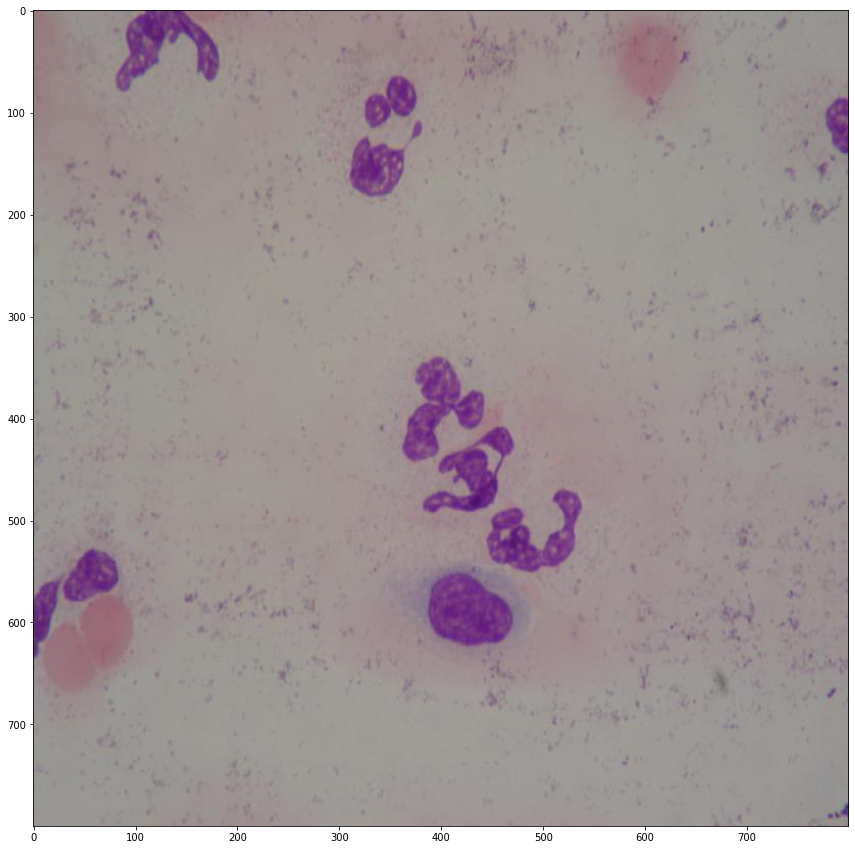

In [ ]:
import random as rand

model = torch.load('/content/object-detection/models/FasterRCNN/cellsModel_final.pt')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

img = Image.open(os.path.join(test_images_path, image_files[rand.randint(0, len(image_files) - 1)])).convert("RGB")
showbbox(model, F.to_tensor(img))